In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels
from pvalannot import pvalannot

from statannotations.Annotator import Annotator

%load_ext autoreload
%autoreload 2

## Mini example used in the README

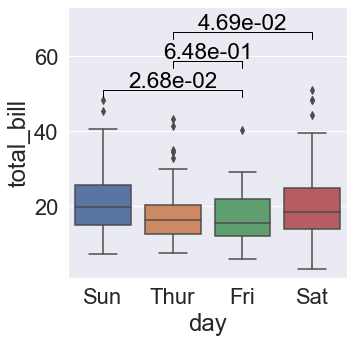

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
from pvalannot import pvalannot

df = sns.load_dataset("tips")
x = "day"
y = "total_bill"
order = ['Sun', 'Thur', 'Fri', 'Sat']
font_scale = 2
sns.set(font_scale=font_scale)
fig = plt.figure(figsize=(5, 5))
ax = sns.boxplot(data=df, x=x, y=y, order=order)
pairs=[("Thur", "Fri"), ("Thur", "Sat"), ("Fri", "Sun")]

pvalannot.AddPvalAnnot(x=x, y=y, data=df, order=order, pairs=pairs, ax=ax, font_scale=1.2)

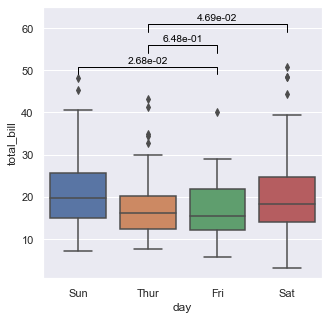

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
from pvalannot import pvalannot

df = sns.load_dataset("tips")
x = "day"
y = "total_bill"
order = ['Sun', 'Thur', 'Fri', 'Sat']
sns.set(font_scale=1)
fig = plt.figure(figsize=(5, 5))
ax = sns.boxplot(data=df, x=x, y=y, order=order)
pairs=[("Thur", "Fri"), ("Thur", "Sat"), ("Fri", "Sun")]

pvalannot.AddPvalAnnot(x=x, y=y, data=df, order=order, pairs=pairs, ax=ax, fig=fig)

## Single-side test

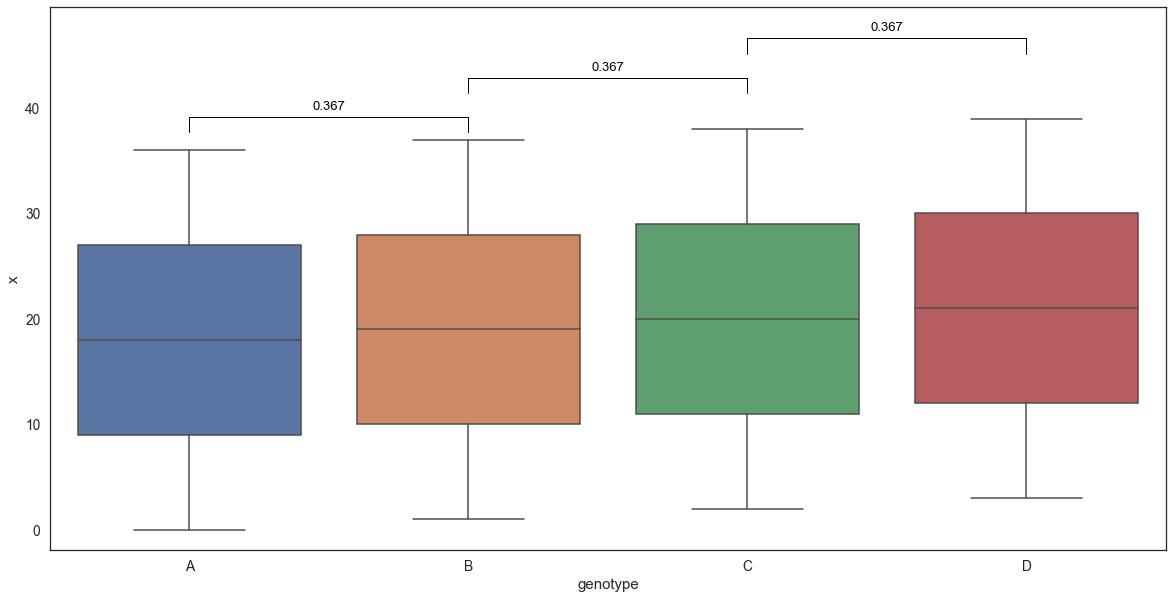

In [99]:
from pvalannot import pvalannot

tmpg = []
tmpm = []
tmpr = []
genotypes = ["A", "B", "C", "D"]
respond = ["R", "NR"]
metric = "x"
k = 0
for i in range(5):
    for g in genotypes:
        tmpg.append(g)
        tmpm.append(k)
        tmpr.append("NR")
        k += 1
for i in range(5, 10):
    for g in genotypes:
        tmpg.append(g)
        tmpm.append(k)
        tmpr.append("R")
        k += 1
tmpdf = pd.DataFrame()
tmpdf["genotype"] = tmpg
tmpdf[metric] = tmpm
tmpdf["respond"] = tmpr
pairs = []
pairs.append([genotypes[2], genotypes[3]])
pairs.append([genotypes[1], genotypes[2]])
pairs.append([genotypes[0], genotypes[1]])
#pairs.append([genotypes[2], genotypes[3]])
sns.set(font_scale=1.25, style="white")
fig = plt.figure(figsize=(20, 10))
ax = sns.boxplot(x="genotype", y=metric, data=tmpdf)

if (0):
    annotator = Annotator(ax, pairs, data=tmpdf, x="genotype", y=metric)
    annotator.configure(test='Mann-Whitney', text_format='star')
    annotator.apply_and_annotate()
else:
    pvalannot.AddPvalAnnot(x="genotype", y=metric, data=tmpdf, pairs=pairs, 
                 ax=ax, fig=fig, fmt="%.3f", func_args={"alternative":"less"})
plt.draw()

## Test with two-level splits (hue)

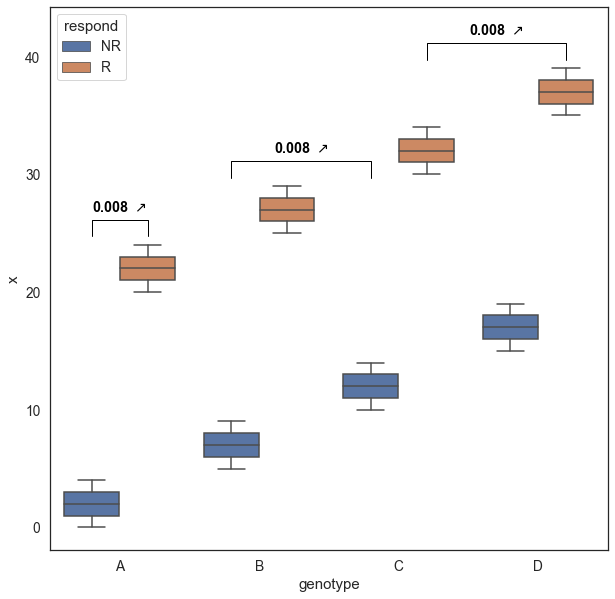

In [100]:
tmpg = []
tmpm = []
tmpr = []
genotypes = ["A", "B", "C", "D"]
respond = ["R", "NR"]
metric = "x"
k = 0
for g in genotypes:
    for i in range(5):
        tmpg.append(g)
        tmpm.append(k)
        tmpr.append("NR")
        k += 1
for g in genotypes:
    for i in range(5, 10):
        tmpg.append(g)
        tmpm.append(k)
        tmpr.append("R")
        k += 1
tmpdf = pd.DataFrame()
tmpdf["genotype"] = tmpg
tmpdf[metric] = tmpm
tmpdf["respond"] = tmpr
pairs = []
pairs.append(((genotypes[2], "R"), (genotypes[3], "R")))
pairs.append(((genotypes[1], "NR"), (genotypes[2], "NR")))
pairs.append(((genotypes[0], "R"), (genotypes[0], "NR")))

#pairs.append((("R", genotypes[2]), ("R", genotypes[3])))
#pairs.append((("NR", genotypes[1]), ("NR", genotypes[2])))
#pairs.append((("R", genotypes[0]), ("NR", genotypes[0])))
#pairs.append([genotypes[2], genotypes[3]])
sns.set(font_scale=1.25, style="white")
fig = plt.figure(figsize=(10, 10))
ax = sns.boxplot(x="genotype", y=metric, hue = "respond", data=tmpdf)

if (0):
    annotator = Annotator(ax, pairs, data=tmpdf, x="genotype", y=metric)
    annotator.configure(test='Mann-Whitney', text_format='star')
    annotator.apply_and_annotate()
else:
    pvalannot.AddPvalAnnot(x="genotype", y=metric, hue = "respond",
                 data=tmpdf, pairs=pairs, ax=ax, fig=fig, fmt="%.3f",
                styles=["trend_arrow", "bold_significant"])
plt.draw()

### Test with pvalue adjustment

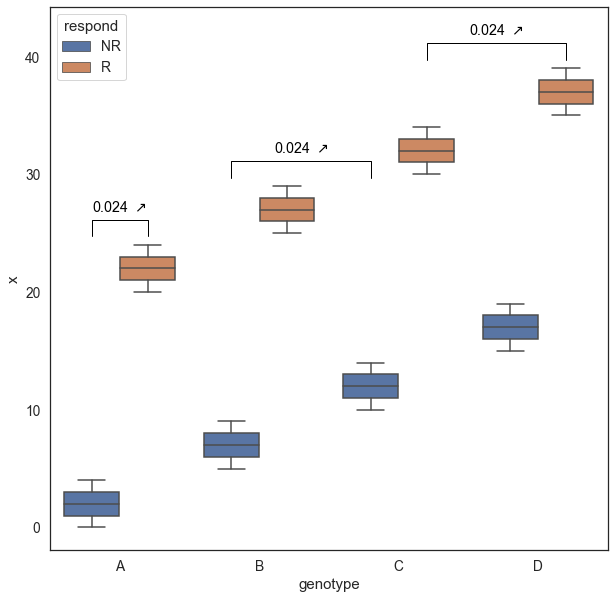

In [101]:
tmpg = []
tmpm = []
tmpr = []
genotypes = ["A", "B", "C", "D"]
respond = ["R", "NR"]
metric = "x"
k = 0
for g in genotypes:
    for i in range(5):
        tmpg.append(g)
        tmpm.append(k)
        tmpr.append("NR")
        k += 1
for g in genotypes:
    for i in range(5, 10):
        tmpg.append(g)
        tmpm.append(k)
        tmpr.append("R")
        k += 1
tmpdf = pd.DataFrame()
tmpdf["genotype"] = tmpg
tmpdf[metric] = tmpm
tmpdf["respond"] = tmpr
pairs = []
pairs.append(((genotypes[2], "R"), (genotypes[3], "R")))
pairs.append(((genotypes[1], "NR"), (genotypes[2], "NR")))
pairs.append(((genotypes[0], "R"), (genotypes[0], "NR")))

#pairs.append((("R", genotypes[2]), ("R", genotypes[3])))
#pairs.append((("NR", genotypes[1]), ("NR", genotypes[2])))
#pairs.append((("R", genotypes[0]), ("NR", genotypes[0])))
#pairs.append([genotypes[2], genotypes[3]])
sns.set(font_scale=1.25, style="white")
fig = plt.figure(figsize=(10, 10))
ax = sns.boxplot(x="genotype", y=metric, hue = "respond", data=tmpdf)

pvalannot.AddPvalAnnot(x="genotype", y=metric, hue = "respond",
        data=tmpdf, pairs=pairs, ax=ax, fig=fig, fmt="%.3f", styles=["trend_arrow"], 
        padjust_func = lambda x: statsmodels.stats.multitest.multipletests(x, method="bonferroni")[1])
plt.draw()

## Paired test

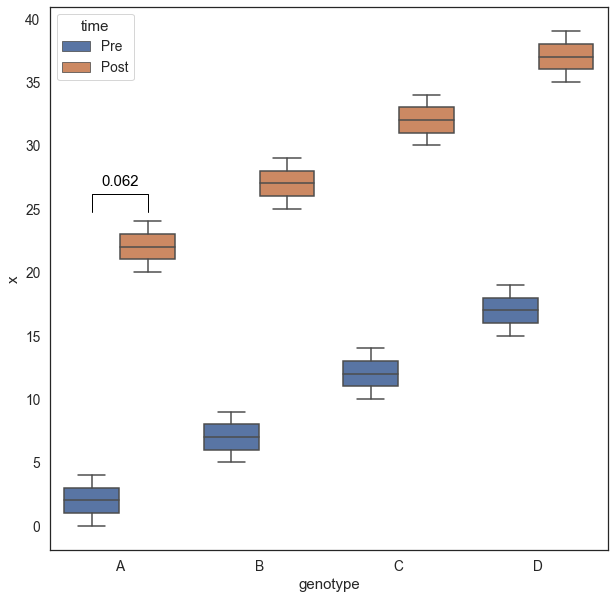

In [102]:
tmpg = []
tmpm = []
tmpr = []
tmpsample = []
genotypes = ["A", "B", "C", "D"]
time = ["Pre", "Post"]
metric = "x"
k = 0
for g in genotypes:
    for i in range(5):
        tmpg.append(g)
        tmpm.append(k)
        tmpsample.append(g + "_" + str(4-i))
        tmpr.append("Pre")
        k += 1
for g in genotypes:
    for i in range(5, 10):
        tmpg.append(g)
        tmpm.append(k)
        tmpsample.append(g + "_" + str(i - 5))
        tmpr.append("Post")
        k += 1
tmpdf = pd.DataFrame()
tmpdf["genotype"] = tmpg
tmpdf[metric] = tmpm
tmpdf["time"] = tmpr
tmpdf["sample"] = tmpsample
pairs = []
pairs.append(((genotypes[2], "Pre"), (genotypes[3], "Post")))
pairs.append(((genotypes[1], "Pre"), (genotypes[2], "Post")))
pairs.append(((genotypes[0], "Pre"), (genotypes[0], "Post")))

#pairs.append((("R", genotypes[2]), ("R", genotypes[3])))
#pairs.append((("NR", genotypes[1]), ("NR", genotypes[2])))
#pairs.append((("R", genotypes[0]), ("NR", genotypes[0])))
#pairs.append([genotypes[2], genotypes[3]])
sns.set(font_scale=1.25, style="white")
fig = plt.figure(figsize=(10, 10))
ax = sns.boxplot(x="genotype", y=metric, hue = "time", data=tmpdf)

pvalannot.AddPvalAnnot(x="genotype", y=metric, hue = "time", pair_test_key = "sample",
                data=tmpdf, pairs=pairs, ax=ax, fig=fig, fmt="%.3f", func = sp.stats.wilcoxon,
                styles=["trend_arrow"])
plt.draw()